In [1]:
import networkx as nx
import random
import time
import matplotlib.pyplot as plt
from community import community_louvain  # Louvain algorithm
from networkx.algorithms.community import girvan_newman
import numpy as np
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import os



In [2]:
file_path = Path(os.path.join('..', 'data', 'ca-GrQc.txt', 'CA-GrQc.txt'))

df_graph = pd.read_csv(filepath_or_buffer=file_path, header=None, names=['from', 'to'], sep='\t', skiprows=4)
display(df_graph.head())

G = nx.from_pandas_edgelist(df=df_graph, source='from', target='to')

print(f'Number of Edges: {G.size()}')
print(f'Number of Nodes: {G.order()}')


,from,to
0,3466,937
1,3466,5233
2,3466,8579
3,3466,10310
4,3466,15931


Number of Edges: 14496
Number of Nodes: 5242


In [3]:
def sample_subgraphs(G, orders, num_samples):
    """Samples subgraphs of different orders."""
    subgraphs = {}
    nodes = list(G.nodes())
    for order in orders:
        subgraphs[order] = [
            G.subgraph(random.sample(nodes, order)).copy() for _ in range(num_samples)
        ]
    return subgraphs

# Define subgraph orders and the number of samples per order
graph_order = G.number_of_nodes()
print(f'Maximal order of the graph: {graph_order}')
orders = [int(graph_order * frac) for frac in np.linspace(0.01, 0.2, 10)]  # 10%-100%
print(f'List of Node Orders: {orders}')
num_samples = 10  # Number of subgraphs per order

# Sample subgraphs
subgraphs = sample_subgraphs(G, orders, num_samples)
print(f'Number of subgraphs: {len(subgraphs)}')

# printing the first 3 subgraphs of each order
for order, graphs in subgraphs.items():
    print(f'Order: {order}')
    for i, graph in enumerate(graphs):
        if i < 3:
            print(f'  Subgraph {i}: {graph.number_of_nodes()} nodes, {graph.number_of_edges()} edges')
        else: 
            break


Maximal order of the graph: 5242
List of Node Orders: [52, 163, 273, 384, 495, 605, 716, 827, 937, 1048]
Number of subgraphs: 10
Order: 52
  Subgraph 0: 52 nodes, 2 edges
  Subgraph 1: 52 nodes, 0 edges
  Subgraph 2: 52 nodes, 0 edges
Order: 163
  Subgraph 0: 163 nodes, 15 edges
  Subgraph 1: 163 nodes, 13 edges
  Subgraph 2: 163 nodes, 18 edges
Order: 273
  Subgraph 0: 273 nodes, 44 edges
  Subgraph 1: 273 nodes, 37 edges
  Subgraph 2: 273 nodes, 39 edges
Order: 384
  Subgraph 0: 384 nodes, 79 edges
  Subgraph 1: 384 nodes, 72 edges
  Subgraph 2: 384 nodes, 62 edges
Order: 495
  Subgraph 0: 495 nodes, 153 edges
  Subgraph 1: 495 nodes, 117 edges
  Subgraph 2: 495 nodes, 149 edges
Order: 605
  Subgraph 0: 605 nodes, 209 edges
  Subgraph 1: 605 nodes, 178 edges
  Subgraph 2: 605 nodes, 158 edges
Order: 716
  Subgraph 0: 716 nodes, 237 edges
  Subgraph 1: 716 nodes, 298 edges
  Subgraph 2: 716 nodes, 219 edges
Order: 827
  Subgraph 0: 827 nodes, 371 edges
  Subgraph 1: 827 nodes, 347 edg

In [4]:
def time_girvan_newman(G, max_levels=3):
    """Time the Girvan-Newman algorithm."""
    start_time = time.time()
    gn_comm = girvan_newman(G)
    for comm in gn_comm: 
        gn_communities = list(comm) # Make sure that girvan_newman algorithm is run
    return time.time() - start_time

def time_louvain(G):
    """Time the Louvain algorithm."""
    start_time = time.time()
    louvain_comm = nx.algorithms.community.louvain_communities(G, seed=42, resolution=1)
    return time.time() - start_time

# Measure runtimes
results = {"order": [], "algorithm": [], "runtime": []}
for order in tqdm(orders, desc="Processing subgraphs"):
    for G_sub in subgraphs[order]:

        # Girvan-Newman
        gn_time = time_girvan_newman(G_sub, max_levels=3)
        results["order"].append(order)
        results["algorithm"].append("Girvan-Newman")
        results["runtime"].append(gn_time)

        # Louvain
        louvain_time = time_louvain(G_sub)
        results["order"].append(order)
        results["algorithm"].append("Louvain")
        results["runtime"].append(louvain_time)


Processing subgraphs: 100%|██████████| 10/10 [1:10:13<00:00, 421.35s/it]


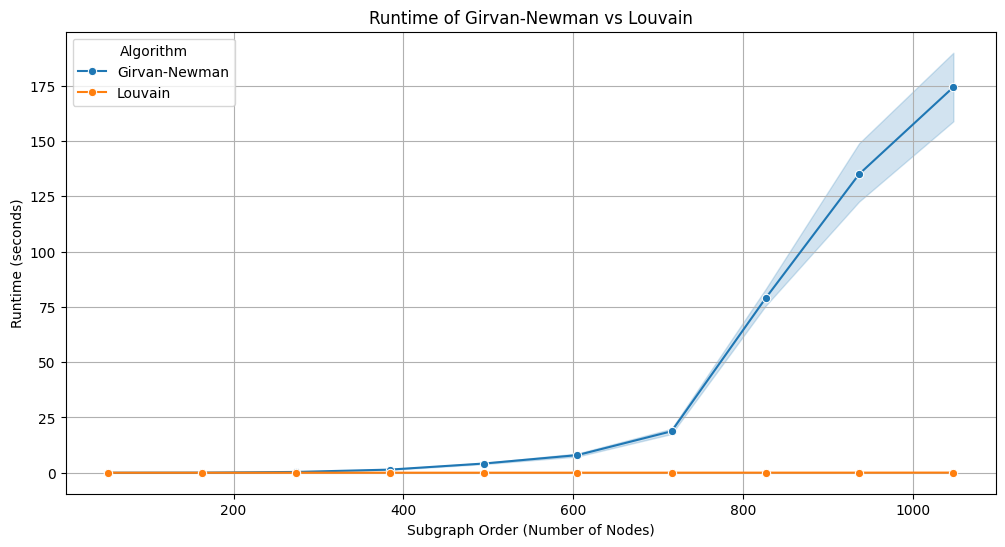

In [5]:
import pandas as pd
import seaborn as sns

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Plot the runtimes
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="order", y="runtime", hue="algorithm", marker="o")
plt.title("Runtime of Girvan-Newman vs Louvain")
plt.xlabel("Subgraph Order (Number of Nodes)")
plt.ylabel("Runtime (seconds)")
plt.legend(title="Algorithm")
plt.grid(True)
plt.show()


<div class="alert alert-block alert-info">

**Observation:**

The **Girvan-Newman algorithm** is a method for detecting communities in networks by iteratively removing edges with the highest betweenness centrality, thereby revealing the underlying community structure. This approach has a computational complexity of $O(m^2n)$ for a network with $n$ nodes and $m$ edges, making it computationally intensive for large networks. This is reflected in the graph, where the runtime of Girvan-Newman grows exponentially with the number of nodes, especially beyond 600 nodes. This makes it impractical for larger networks.

In contrast, the **Louvain algorithm**, with a time complexity of $O(n \log n)$, has a consistently low runtime across all graph sizes. The efficiency of the algorithm is due to its greedy optimisation approach, which iteratively maximises modularity in a localised manner. This scalability is evident in the graph, where Louvain's runtime remains nearly constant even for larger networks.

**Practical Implications:**.  
The Girvan-Newman algorithm provides a detailed hierarchical decomposition of the network, but is more suitable for smaller graphs due to its high computational cost. On the other hand, the Louvain algorithm is the preferred choice for clustering large networks due to its scalability and faster performance.


</div>